# Мобильные приложения - Выделение групп пользователей на основе поведения

Мы представляем интернет-сервис по продаже вещей "Ненужные вещи". 

**Цель исследования** - определить модель поведения пользователей мобильного приложения.

**Задачи исследования**:
- оценить уровень удержания, конверсию, время, проведенное в приложении и частоту пользования приложением пользователями, 
- сегментировать пользователей на основе действий, 
- оценить различия сегментов по активности пользователей, 
- проверить гипотезу о взаимосвязи конверсии и удержания и источников установки приложения,
- проверить гипотезу о взаимосвязи частоты пользования приложением от дня недели (будние, выходные дни).

**Ход исследования**

Для анализа мы используем данные пользователей мобильного приложения - информацию о событиях и действиях пользователя в приложении с указанием времени события, а также данные о источнике, из которого пользователь установил приложение.

О качестве данных нам ничего неизвестно, поэтому перед проведением исследования понадобится обзор и предобработка данных: обработаем пропуски и дубликаты в случае наличия, приведем данные к необходимым типам, проведем дополнительные расчеты.

Затем мы проверим данные и оценим, какой объем данных имеется, какой период они покрывают, как представлены группы пользователей по источнику установки приложения.

После этого проведем сегментацию пользователей - разделение на группы.

На основе сегментации проанализируем различия между группами пользователя по основным показателям активности. 

Затем проверим гипотезы нашего исследования.

Таким образом, решение пройдет в пять этапов.

## Обзор и предобработка данных

### Обзор данных

Составим представление о данных. Импортируем специальную библиотеку pandas для обработки и анализа данных, а также другие библиотеки и объекты. 

In [1]:
import pandas as pd # импорт библиотеки pandas
#import datetime as dt  # импорт библиотеки datetime для работы со временем
import matplotlib.pyplot as plt # импорт части библиотеки matplotlib для работы с диаграммами
import seaborn as sns # импорт библиотеки seaborn для работы с диаграммами
from datetime import datetime, timedelta
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
#from plotly import graph_objects as go # импортируем набор методов для работы с интерактивными графиками
#import numpy as np # импорт библиотеки numpy для математических вычислений
import math # импорт библиотеки math для математических вычислений
from scipy import stats as stats # импорт модуля stats для статистических методов

Прочитаем файлы и сохраним в переменные `mobile_sourсes`, `mobile_dataset`, а также выведем на экран начало таблиц.

In [2]:
# чтение файла с данными и сохранение в logs
try:
    # адрес на платформе Яндекса
    mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')  
except:
    # адрес в локальном окружении
    mobile_sources = pd.read_csv('mobile_sources.csv')
    mobile_dataset = pd.read_csv('mobile_dataset.csv')
# получение первых 5 строк таблиц
display(mobile_sources.head(5)) 
display(mobile_dataset.head(5)) 

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Получим общую информацию о таблицах. Начнем с таблицы `mobile_sourсes`.

In [3]:
mobile_sources.info() # получение общей информации о данных в таблице mobile_sourсes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Таблица `mobile_sourсes` (источники установки приложения)
Каждая запись в таблице - это пользователь и источник установки приложения.

В таблице 2 столбца. Согласно документации к данным:
* `userId` — идентификатор пользователя, тип данных object;
* `source` — источник установки приложения, тип данных object.

Представлены следующие источники:
   1. google;
   2. yandex;
   2. other - другой. 

В таблице 4293 значения в каждом столбце, пропущенных значений нет.
Названия всех столбцов необходимо привести к хорошему стилю.

In [4]:
mobile_dataset.info() # получение общей информации о данных в таблице mobile_dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Таблица `mobile_dataset` (данные приложения)
Каждая запись в логе - это действие или событие.

В таблице 3 столбца. Согласно документации к данным:
* `event.time` - время совершения события,
* `event.name` — название события;
* `user.id` — идентификатор пользователя.

Представлены следующие события:
   1. advert_open - открытие карточки объявления;
   2. photos_show  - просмотр фотографий в объявлении;      
   3. tips_show - пользователь увидел рекомендованные объявления;         
   4. tips_click  - пользователь кликнул по рекомендованному объявлению;   
   5. contacts_show и show_contacts - пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления;
   6. contacts_call - пользователь позвонил по номеру телефона на карточке объявления;
   7. map - пользователь открыл карту размещенных объявлений;
   8. search_1 - search_7 - разные события, связанные с поиском по сайту;
   9. favorites_add -  добавление объявления в избранное.

У всех столбцов тип данных - object.

В таблице 74 197 значений в каждом столбце, пропущенных значений нет.
Названия всех столбцов необходимо привести к хорошему стилю. Столбец `event.time` необходимо будет преобразовать в формат дата/время.

**Выводы**

Данные для анализа содержатся в таблицах `mobile_sources` и `mobile_dataset`, они включают информацию о событиях пользователей и их источникам установки приложения. Для достижения целей исследования необходимо будет провести предобработку: привести данные к необходимым форматам, привести названия столбцов к хорошему стилю и убедиться в качестве данных. 

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Приведение названий столбцов к хорошему стилю

Заменим названия столбцов в таблицах - приведем к snake_case - нижний регистр с нижними поджчеркиваниями.

In [5]:
# Переименование столбца в mobile_sourсes
mobile_sources = mobile_sources.rename(columns={'userId':'user_id'})
# Переименование столбцов
mobile_dataset.columns = ['event_time', 'event_name','user_id']
# Проверка - вывод названий столбцов
print(mobile_sources.columns)
print(mobile_dataset.columns)

Index(['user_id', 'source'], dtype='object')
Index(['event_time', 'event_name', 'user_id'], dtype='object')


Теперь названия столбцов в порядке. 

### Преобразование типов данных

 Cтолбец `event_time` преобразуем в формат дата/время.

In [6]:
# Изменение типа данных с помощью метода .to_datetime()
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
# Запрос получившегося типа данных
print(type(mobile_dataset['event_time'].dtype))
# Проверка - получение первых 5 строк таблицы
mobile_dataset.head()

<class 'numpy.dtype[datetime64]'>


,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Замена произведена успешно.

### Проверка данных на аномалии и дубликаты

Проверим поля event_name, source на аномалии.

In [7]:
# Запрос значений поля
print(mobile_dataset.event_name.value_counts())
print(mobile_sources.source.value_counts())

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64
yandex    1934
other     1230
google    1129
Name: source, dtype: int64


Аномалий в содержании полей event_name и source нет, однако есть дубликаты: contacts_show и show_contacts, также к дубликатам можно отнести все значения search - они демонстрируют различные действия, но в контексте нашего исследования это не принципиально, мы можем их объединить.

In [8]:
# Замена значений в поле
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace(r'_[1-7]','', regex=True)
# Проверка - запрос значений полей
mobile_dataset.event_name.value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Теперь проверим таблицы на явные дубликаты.

In [9]:
# Запрос количества явных дубликатов
print(mobile_dataset.duplicated().sum())
print(mobile_sources.duplicated().sum())

0
0


Явных дубликатов в таблицах нет. 
Мы проверили данные на аномалии и дубликаты, устранили небольшие погрешности и теперь можем приступать к дальнейшему анализу

### Расчет дополнительных показателей

Выделим в отдельный столбец информацию о дате события и дне недели.

In [10]:
# Выделение даты с помощью индекса .dt.date 
mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date 
mobile_dataset['event_weekday'] = mobile_dataset['event_time'].dt.weekday
# Запрос получившегося типа данных
print(type(mobile_dataset['event_date'].dtype))
print(type(mobile_dataset['event_weekday'].dtype))
# Проверка - получение первых 5 строк таблицы
mobile_dataset.head()

<class 'numpy.dtype[object_]'>
<class 'numpy.dtype[int64]'>


,event_time,event_name,user_id,event_date,event_weekday
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0


Добавление прошло успешно.

Для полноценного анализа лучше использовать не отдельные пользовательские действия, а сессии. В дальнейшем стоит логировать сессии пользователей, но пока информации о сессиях у нас нет, поэтому попробуем рассчитать номер сессии для каждого пользователя самостоятельно. Установим длительность паузы между сессиями в 30 минут - после этого сессия "закрывается", а дальнейшие действия пользователя относятся к следующей сессии. 

In [11]:
# Установление длительности паузы, после которой сессия закрывается
time_difference = '30Min'
# Сортировка таблицы для верного распределения действий по секциям
mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time']) 
# Определение разницы в каждой группе, кумулятивная сумма по пользователям 
group = (mobile_dataset.groupby('user_id')['event_time'].diff() > pd.Timedelta(time_difference)).cumsum()
# Установление номеров сессии
mobile_dataset['session_id'] = mobile_dataset.groupby(['user_id', group], sort=False).ngroup() + 1
# Проверка - получение первых 10 строк таблицы
display(mobile_dataset.head(10))
print(f'Всего событий - {len(mobile_dataset)}, сессий - {mobile_dataset.session_id.max()}.')

,event_time,event_name,user_id,event_date,event_weekday,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
831,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
832,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
836,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
839,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2,2


Всего событий - 74197, сессий - 10368.


### Агрегация данных

Подготовим сводную таблицу по уникальным пользователям и внесем в нее все необходимые данные:
* количество действий, 
* количество сессий,
* дата первого использования приложения, 
* дата последнего использования приложения, 
* разница между первым и последним днем использования приложения,
* количество дней использования приложения,
* факт конверсии, 
* дата конверсии,
* источник установки приложения. 

Начнем с расчета основных характеристик: дат использования и количества событий и сессий.

In [12]:
# Создание сводной таблицы с информацией о датах, событиях и сессиях по пользователям
events_pivot = mobile_dataset.pivot_table(
    values=['event_name','session_id', 'event_date'] ,
    index='user_id', 
    aggfunc={'event_name':'count', 'session_id':'nunique', 'event_date':['min', 'max', 'nunique']}, 
).reset_index()
# Переименование столбцов
events_pivot.columns = ['user_id','last_event', 'first_event', 'days_of_use', 'event_count', 'session_count']
# Добавление столбца
events_pivot['date_difference_in_days'] = (events_pivot['last_event'] - events_pivot['first_event'] ) / (
    np.timedelta64(1, 'D')
)
# Изменение порядка столбцов
events_pivot.reindex(['user_id','event_count', 'session_count', 'first_event', 
                      'last_event', 'date_difference_in_days', 'days_of_use'], 
                     axis=1)
# Проверка - демонстрация первых 5 строк таблицы
events_pivot.head(5)

,user_id,last_event,first_event,days_of_use,event_count,session_count,date_difference_in_days
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-07,4,35,4,15.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,2019-10-19,6,71,6,15.0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1,10,1,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-31,2019-10-18,6,32,6,13.0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-29,2019-10-25,3,8,3,4.0


Для построения таблицы необходимо выделить пользователей, совершивших и не совершивших конверсию.

In [13]:
# Выделение пользователей, у которых произошла и не произошла конверсия
users_contacts_shown = mobile_dataset.loc[mobile_dataset['event_name'] == 'contacts_show', 'user_id'].unique()
users_contacts_not_shown = mobile_dataset.query('user_id not in @users_contacts_shown')['user_id'].unique()
print(f'Всего пользователей, просмотревших контакты - {len(users_contacts_shown)}, \
не просмотревших контакты - {len(users_contacts_not_shown)}.')

Всего пользователей, просмотревших контакты - 981, не просмотревших контакты - 3312.


Теперь добавим факт и дату конверсии в таблицу.

In [14]:
# Расчет даты конверсии
conversion_date = mobile_dataset.query(
    'event_name == "contacts_show"').pivot_table(index='user_id', 
                                                                  values='event_date', 
                                                                  aggfunc='min').reset_index()
conversion_date.columns = ['user_id','conversion_date']
# Проверка - демонстрация первых 5 строк таблицы
display(conversion_date.head(5))
# Добавление данных о дате конверсии в сводную таблицу
events_pivot = events_pivot.merge(conversion_date, on = 'user_id', how='left')
# Добавление столбца с информацией о конверсии
events_pivot['user_conversion'] = np.where(events_pivot['conversion_date'].isna(), 0, 1)
# Добавление столбца с информацией об источнике установки приложения

events_pivot = events_pivot.merge(mobile_sources, on = 'user_id', how='left')
## Проверка - демонстрация первых 5 строк таблицы
display(events_pivot.head(5))


,user_id,conversion_date
0,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20
1,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25
2,005fbea5-2678-406f-88a6-fbe9787e2268,2019-10-11
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,2019-10-20
4,007d031d-5018-4e02-b7ee-72a30609173f,2019-10-22


,user_id,last_event,first_event,days_of_use,event_count,session_count,date_difference_in_days,conversion_date,user_conversion,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-07,4,35,4,15.0,NaN,0,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,2019-10-19,6,71,6,15.0,2019-10-20,1,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1,10,1,0.0,NaN,0,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-31,2019-10-18,6,32,6,13.0,NaN,0,google
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-29,2019-10-25,3,8,3,4.0,2019-10-25,1,yandex


Сводная таблица с информацией о пользователях успешно создана. 

Подготовим сводную таблицу по сессиям, включим в нее следующую информацию:
- идентификатор сессии,
- пользователь,
- дата,
- начало сессии,
- конец сессии, 
- длительность сессии,
- часть дня, в который проходит сессия, 
- количество действий в сессии,
- факт конверсии в рамках сессии,
- факт конверсии у пользователя,
- содержание сессии.

Подготовим функцию для учета действий в сессии. 

In [15]:
# Создание функции демонстрации списка действий в сессии
def list_names(series):
    unique_names = ''
    for element in series:
        if element not in unique_names:
            unique_names = unique_names + ' ' + element
    return unique_names


Теперь создадим сводную таблицу с информацией о сессиях.

In [16]:
# Создание сводной таблицы с информацией о сессиях
sessions_pivot = mobile_dataset.pivot_table(
    values=['event_name','user_id', 'event_date', 'event_time'] ,
    index='session_id', 
    aggfunc={'user_id':'first', 'event_name':['count', list_names], 'event_date':'min', 'event_time' : ['min', 'max']}, 
).reset_index()
sessions_pivot.head(5)

# Переименование столбцов
sessions_pivot.columns = ['session_id', 'event_date', 'events_in_session', 'event_names', 'last_event_time', 'first_event_time', 'user_id', ]
# Добавление столбцов
min_duration = pd.Timedelta(value = 1, unit='minutes')
sessions_pivot['session_duration_min'] = round((sessions_pivot.last_event_time - 
                                      sessions_pivot.first_event_time + 
                                      min_duration) / np.timedelta64(1, 'm'), 2)

# Подготовка функции для расчета времени суток
def session_daypart(time):
    if time.hour < 5:
        return 'ночь'
    if time.hour < 11:
        return 'утро'
    if time.hour < 17:
        return 'день'
    if time.hour < 23:
        return 'вечер'
    else:
        return 'ночь'
# Добавление столбца со временем суток 
sessions_pivot['daytime'] = sessions_pivot['first_event_time'].apply(session_daypart)
# Добавление столбца с информацией о конверсии в рамках сессии
sessions_pivot['session_conversion'] = np.where(sessions_pivot['event_names'].str.contains('contacts_show'), 1, 0)
# Добавление столбца с информацией о конверсии пользователя
sessions_pivot = sessions_pivot.merge(events_pivot[['user_conversion', 'user_id']], on = 'user_id')
# Изменение порядка столбцов
sessions_pivot.reindex(['session_id', 'user_id', 'event_date', 'first_event_time', 'last_event_time',
                      'session_duration_min', 'daytime', 'events_in_session', 'session_conversion', 
                       'user_conversion', 'events_in_session'], 
                     axis=1)
# Проверка - демонстрация первых 5 строк таблицы
sessions_pivot.head(5)

,session_id,event_date,events_in_session,event_names,last_event_time,first_event_time,user_id,session_duration_min,daytime,session_conversion,user_conversion
0,1,2019-10-07,9,tips_show,2019-10-07 13:49:41.716617,2019-10-07 13:39:45.989359,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,10.93,день,0,0
1,2,2019-10-09,4,map tips_show,2019-10-09 18:42:22.963948,2019-10-09 18:33:55.577963,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,9.46,вечер,0,0
2,3,2019-10-21,14,tips_show map,2019-10-21 20:07:30.051028,2019-10-21 19:52:30.778932,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,15.99,вечер,0,0
3,4,2019-10-22,8,map tips_show,2019-10-22 11:30:52.807203,2019-10-22 11:18:14.635436,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,13.64,день,0,0
4,5,2019-10-19,9,search photos_show,2019-10-19 21:59:54.637098,2019-10-19 21:34:33.849769,00157779-810c-4498-9e05-a1e9e3cedf93,26.35,вечер,0,1


Сводные таблицы по пользователям и сессиям подготовлены. 

Подготовим также таблицу для дашборда:
1. Постройте диаграмму распределения количества событий по типу события
2. Добавьте индикатор количества пользователей
3. Добавьте фильтр дашборда по дате совершения события

In [59]:
dashboard_table = mobile_dataset[['event_name', 'event_date', 'user_id']]
dashboard_table.to_csv('dashboard_app.csv')
dashboard_table

,event_name,event_date,user_id
805,tips_show,2019-10-07,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
806,tips_show,2019-10-07,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
809,tips_show,2019-10-07,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
820,tips_show,2019-10-07,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
830,tips_show,2019-10-07,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
...,...,...,...
72584,tips_show,2019-11-03,fffb9e79-b927-4dbb-9b48-7fd09b23a62b
72589,contacts_show,2019-11-03,fffb9e79-b927-4dbb-9b48-7fd09b23a62b
72684,tips_show,2019-11-03,fffb9e79-b927-4dbb-9b48-7fd09b23a62b
72688,tips_show,2019-11-03,fffb9e79-b927-4dbb-9b48-7fd09b23a62b


**Вывод:**
 
 В рамках подготовки данных мы привели названия столбцов хорошему стилю, там где было необходимо, привели данные к необходимому формату (даты-времени), удалили дубликаты в данных, рассчитали необходимые показатели. Полученные данные мы объединили в сводные таблицы по пользователям и сессиям. Следует отметить, что в анализе мы будем использовать искусственно собранные сессии, а не сгенерированные аналитической системой на основании активности пользователя.

## Исследовательский анализ данных

Провелем первичный анализ данных: оценим общее количество событий и пользователей, оценим основные показатели активности пользователей: уровень удержания, конверсию, время, проведенное в приложении и частоту пользования приложением пользователями. 

### Общая информация о пользователях

Рассчитаем количество событий и уникальных пользователей.

In [18]:
print('Всего событий в приложении - ', mobile_dataset.event_name.count())
print('По видам они распределены следующим образом:')
print(mobile_dataset.event_name.value_counts())

Всего событий в приложении -  74197
По видам они распределены следующим образом:
tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64


Рассчитаем количество уникальных пользователей приложения.

In [19]:
print (f'Всего уникальных пользователей - {mobile_dataset.user_id.nunique()}, из них просмотрело контакты - {len(users_contacts_shown)} ' )
print(f'Уровень конверсии - {len(users_contacts_shown) / mobile_dataset.user_id.nunique(): .2%}')

Всего уникальных пользователей - 4293, из них просмотрело контакты - 981 
Уровень конверсии -  22.85%


Определим среднее количество событий на пользователя.

In [20]:
print ('Среднее количество событий на пользователя -', 
       round(mobile_dataset.event_name.count() / mobile_dataset.user_id.nunique()))

Среднее количество событий на пользователя - 17


Среднее количество событий на пользователя не позволяет представить, как эти события между пользователями распределены. Построим гистограмму количества событий. 

In [21]:
sessions_pivot.event_names.value_counts().head(20)

 tips_show                           2677
 photos_show                         1320
 search                               762
 map tips_show                        547
 search photos_show                   524
 search tips_show                     409
 tips_show contacts_show              342
 tips_show map                        203
 contacts_show                        195
 map advert_open tips_show            172
 tips_show tips_click                 162
 advert_open                          134
 map                                  134
 advert_open tips_show                133
 contacts_show contacts_call          120
 search map tips_show                 108
 photos_show search                   106
 map tips_show contacts_show           94
 photos_show contacts_show             85
 search map advert_open tips_show      81
Name: event_names, dtype: int64

Наиболее распространенные сценарии сессий состоят из 
- просмотра объявлений, 
- просмотра фотографий,
- поиска,
- просмотра объявлений на карте,
- поиска и просмотра объявлений,
- взаимодействия с рекламой,

In [22]:
sessions_pivot.daytime.value_counts(normalize=True)

день     0.407311
вечер    0.359279
утро     0.154225
ночь     0.079186
Name: daytime, dtype: float64

Большинство сессий происходит днем (41%) и вечером (36%).  Это может быть связано с особенностями приложения - чтобы связаться с человеком для покупки-продажи вещи нужно, чтобы это было удобное время для переговоров - день или вечер.

In [23]:
sessions_pivot.pivot_table(index='session_conversion',
                          aggfunc={'events_in_session':'mean', 'session_duration_min': 'mean'})

,events_in_session,session_duration_min
session_conversion,,
0,6.622620,12.454926
1,9.871991,21.117651


Сессии в которые происходят конверсии содержат в 1,5 раза больше событий и по длительности почти в два раза длиннее сессий, в которых события не происходят. 

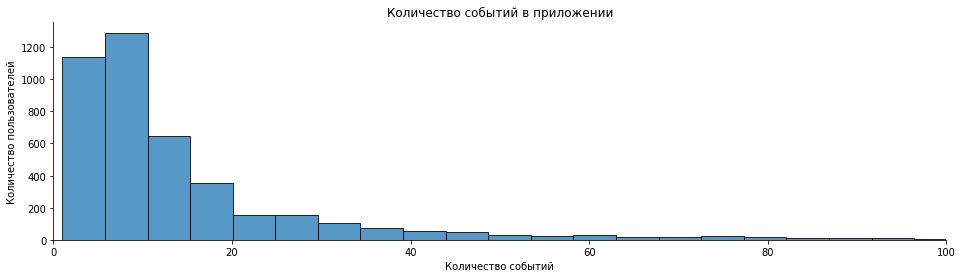

In [24]:
# Определение размера графика
plt.figure(
    figsize=(16, 4)
)  
# Построение диаграммы с распределением событий по датам
ax = sns.histplot(
    x='event_count', 
    data=events_pivot,
    color='#1F77B4',
    bins = 100,
)
ax.set_xlim(0,100)
sns.despine()
# Добавление подписей графика и осей
plt.title('Количество событий в приложении')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
# Демонстрация графика
plt.show()

На гистограмме мы отразили пользователей, которые совершили до 100 действий в приложении. Как мы видим, наибольшее количество пользователей совершает небольшое количество действий. Проанализирем общие данные по пользователям.

In [25]:
events_pivot.describe()

,days_of_use,event_count,session_count,date_difference_in_days,user_conversion
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,1.820871,17.283252,2.415094,2.613324,0.228512
std,1.762537,29.130677,3.536466,5.187808,0.419923
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,5.000000,1.000000,0.000000,0.000000
50%,1.000000,9.000000,1.000000,0.000000,0.000000
75%,2.000000,17.000000,3.000000,3.000000,0.000000
max,25.000000,478.000000,99.000000,27.000000,1.000000


Данные по пользователям показывают: есть существенная разница в активности пользователей. Средниий уровень конверсии - 22%. Есть небольшое количество наиболее активных пользователей - они совершают до 478 действий, либо имеют до 99 сессий за период, при этом для 75% пользователей общее количество дней пользования приложением не превышает 2, за это время они успевают выполнить до 3 сессий с общим количеством действий 17.

Проанализируем сводную информацию о сессиях.

In [26]:
sessions_pivot.describe()

,session_id,events_in_session,session_duration_min,session_conversion,user_conversion
count,10368.00000,10368.000000,10368.000000,10368.000000,10368.000000
mean,5184.50000,7.156346,13.877825,0.164255,0.368345
std,2993.12813,9.581106,19.860204,0.370525,0.482379
min,1.00000,1.000000,1.000000,0.000000,0.000000
25%,2592.75000,2.000000,1.350000,0.000000,0.000000
50%,5184.50000,4.000000,6.590000,0.000000,0.000000
75%,7776.25000,9.000000,18.422500,0.000000,1.000000
max,10368.00000,149.000000,322.970000,1.000000,1.000000


Более 70 000 событий были объединены нами в примерно 10 000 сессий. В среднем в сессию входит 7 событий, а средняя длительность сессии составляет около 14 минут. Включают демонстрацию контактов 16% сессий. 

**Вывод**
Мы подготовили данные: оценили общий объем данных - у нас есть информация о более, чем 4 тысячах пользователей, из которых 22% просмотрели контакты (в нашем случае - это показатель конверсии), и свыше 70 000 событий. 

### Подготовка функций для расчета и визуализации основных показателей: удержание и конверсия

#### Функция расчета удержания

In [27]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец user_conversion в передаваемый dimensions список
    dimensions = ['user_conversion'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_event <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'first_event_time']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['first_event_time'].dt.date - result_raw['first_event']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_event_time'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### Функция расчета времени в приложении

Рассчитаем время в приложении

In [28]:
# функция для расчёта времени в приложении

def get_time_in_app(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец user_conversion в передаваемый dimensions список
    dimensions = ['user_conversion'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_event <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта
    result_raw = result_raw.merge(
        sessions.pivot_table(index = ['user_id', 'event_date'], 
                                   aggfunc ={'session_duration_min': 'sum', 'first_event_time': 'first'}), 
        on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['first_event_time'].dt.date - result_raw['first_event']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.query('lifetime < 7').pivot_table(
            values = 'session_duration_min', 
            index = dims, 
            columns = 'lifetime')
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # возвращаем таблицу и сырые данные
    return result_raw, result_grouped

#### Функция расчета количества действий в приложении

Подготовим функцию для расчета количества действий

In [29]:
# функция для расчёта времени в приложении

def get_event_count(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец user_conversion в передаваемый dimensions список
    dimensions = ['user_conversion'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_event <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions.pivot_table(index = ['user_id', 'event_date'], 
                                   aggfunc ={'events_in_session': 'sum', 'first_event_time': 'first'}), 
        on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['first_event_time'].dt.date - result_raw['first_event']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.query('lifetime < 7').pivot_table(
            values = 'events_in_session', 
            index = dims, 
            columns = 'lifetime')
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # возвращаем таблицу и сырые данные
    return result_raw, result_grouped

Подготовим функцию для расчета удержания потребителей. 

#### Функция расчета расчета конверсии

In [30]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_event <= @last_suitable_acquisition_date')

    # определяем дату и время первого просмотра контактов для каждого пользователя
    first_contact_show = (
        sessions.query('session_conversion == 1')
        .sort_values(by=['user_id', 'first_event_time'])
        .groupby('user_id')
        .agg({'event_date': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_contact_show[['user_id', 'event_date']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_date'] - result_raw['first_event']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

   

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped

#### Функция визуализации удержания

Подготовим функцию для визуализации удержания

In [31]:
# функция для визуализации удержания

def plot_retention(retention, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(12, 5))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм


    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'user_conversion'])

    # в таблице графиков — два столбца и две ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(1, 2, 1)
    retention.query('user_conversion == 1').droplevel('user_conversion').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей, просматривающих контакты')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    retention.query('user_conversion == 0').droplevel('user_conversion').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей, не просматривающих контакты')

    
    plt.tight_layout()
    plt.show()

#### Функция визуализации конверсия

Подготовим функцию для визуализации конверсии.

In [32]:
# функция для визуализации конверсии

def plot_conversion(conversion, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
   # conversion_history = conversion_history.drop(columns=['cohort_size'])[
    #    [horizon - 1]
    #]

    # первый график — кривые конверсии
    conversion.T.plot(grid=True)
    plt.legend()
    plt.ylim((0,0.25))
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    plt.tight_layout()
    plt.show()

Функции для расчета удержания и конверсии готовы, а также функции для их визуализации готовы, теперь мы можем проанализировать пользователей по основным характеристикам их активности.

### Расчет основных показателей: удержание, время, проведенное в приложении, частота действий, конверсия

Определим, данными за какой период мы распологаем. Для этого найдем минимальную и максимальную дату событий.

In [33]:
print(f'Минимальная дата событий - {mobile_dataset.event_time.min():%d.%m.%Y}')
print(f'Максимальная дата событий - {mobile_dataset.event_time.max():%d.%m.%Y}')

Минимальная дата событий - 07.10.2019
Максимальная дата событий - 03.11.2019


У нас есть информация по событиям от 07 октября до 3 ноября 2019 года. Для анализа событий нам необходимо определить дату наблюдения - это максимальная дата событий и горизонт анализа. 
В качества горизонта анализа используем неделю - за этот срок пользователь может ознакомиться с функционалом и определиться с характером использования приложения. 

In [34]:
# Установление даты наблюдения
observation_date = mobile_dataset.event_time.max()
# Установление горизонта анализа
horizon_days = 7

#### Расчет удержания пользователей

Рассчитаем удержание пользователей.

In [35]:
# Расчет удержания
retention_raw, retention_grouped, retention_history = get_retention(
    events_pivot,
    sessions_pivot,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)
# Демонстрация общей таблицы удержания
retention_grouped

,cohort_size,0,1,2,3,4,5,6
user_conversion,,,,,,,,
0,2725,1.0,0.114128,0.067156,0.065688,0.050642,0.051009,0.040734
1,823,1.0,0.249089,0.182260,0.167679,0.103281,0.103281,0.105711


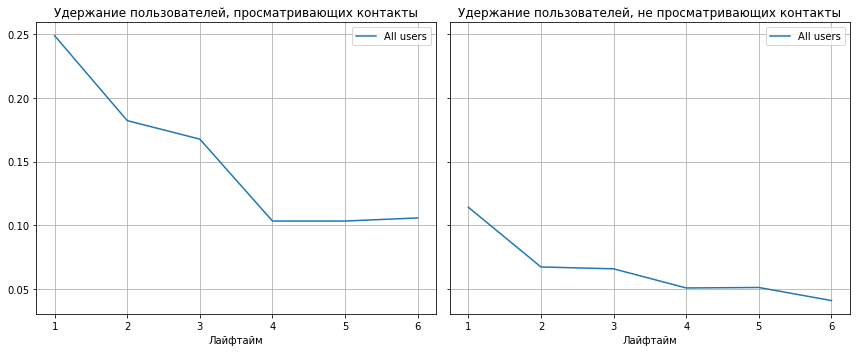

In [36]:
# Визуализация удержания
plot_retention(retention_grouped, horizon = 7, window=7)

Мы видим, что уровень удержания на 7-дневном горизонте существенно различается для пользователей, которые просмотрели контакты и пользователей не просмотревших их. Для пользователей с конверсией показатель через неделю составляет свыше 10%, тогда как для пользователей, не просмотревших контакты аналогичный показатель составляет около 4%.

#### Расчет времени, проведенного в приложении, для пользователей

Рассчитаем время, проведенное в приложении для пользователей.  

In [37]:
# Расчет времени, проведенного в приложении 
time_raw, time_grouped = get_time_in_app(
    events_pivot,
    sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=[],
    ignore_horizon=False,
)
time_grouped

,cohort_size,0,1,2,3,4,5,6
user_conversion,,,,,,,,
0,2725,17.894763,14.582315,13.624208,12.399330,12.732609,14.548705,13.724685
1,823,24.802211,23.320244,19.788467,16.152536,17.998824,16.480000,18.685632


Мы видим, что в среднем пользователи, просматривающие контакты проводят больше время в приложении, чем не просматривающие, однако и заметно отсутствие линейного снижения времени, проведенного в приложении.

Пользователи, не просматривающие контакты постепенно сокращают свое время в приложении, однако пользователи, просматривающие контакты взаимодействуют с приложением достаточно стабильно.

#### Расчет частоты действий пользователей

Оценим частоту действий. 

In [38]:
# Расчет количества действий, проведенного в приложении 
events_raw, events_grouped = get_event_count(
    events_pivot,
    sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=[],
    ignore_horizon=False,
)
events_grouped

,cohort_size,0,1,2,3,4,5,6
user_conversion,,,,,,,,
0,2725,9.928073,7.681672,7.508197,6.860335,7.594203,7.474820,6.540541
1,823,12.166464,11.551220,9.206667,7.818841,8.988235,8.611765,9.574713


Среднее количество действий за день также различается для пользователей, просматривающих контакты и не просматривающих контакты. В среднем пользователи с конверсией на четверть более активны, по сравнению с пользователями, не совершившим конверсии.

#### Расчет конверсии пользователей

Рассчитаем конверсию пользователей. 

In [39]:
# Расчет конверсии
conversion_raw, conversion_grouped = get_conversion(
    profiles = events_pivot,
    sessions = sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=[],
    ignore_horizon=False,
)
conversion_grouped

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
cohort,,,,,,,,
All users,3548,0.172492,0.186584,0.194758,0.200113,0.204622,0.209414,0.213641


<Figure size 1080x360 with 0 Axes>

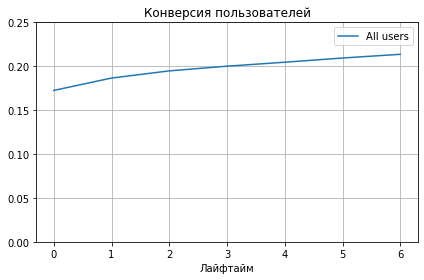

In [40]:
plot_conversion(conversion_grouped, horizon=7)

Конверсия пользователй до просмотра контактов на недельном горизонте составляет более 21%. 

Оценим общий уровень конверсии по всему датасету.

In [41]:
# Расчет общего уровня конверсии по всем пользователям в датасете
events_pivot.user_conversion.mean()

0.22851153039832284

**Вывод:**

Таким образом, общая активность пользователей на горизонте в 1 неделю характеризуется следущими показателями:
- удержание пользователей с конверсией составляет около 10%, без конверсии - 4%,
- время, проведенное в приложении в день после начального ознакомительного периода для пользователей с конверсией составляет 16-20 минут, для пользователей без конверсии - 12-14 минут,
- частота действий для пользователей до конверсии составляет 6-7 действий в день после ознакомительного периода, для пользователей с конверсией - 8-10 действий в день,
- общий уровень конверсии в первый день установки составляет 17%, на 7 сутки доходит до 21%, по всем пользователям составляет около 23%. 

## Сегментация пользователей

Разделим пользователй на сегменты. Воспользуемся методом кластеризации.

### Матрица корреляции

Подготовим таблицу и рассмотрим матрицу корреляции

In [42]:
# Преобразование источника в измеряемый тип
events_pivot = pd.get_dummies(events_pivot, columns=['source'])


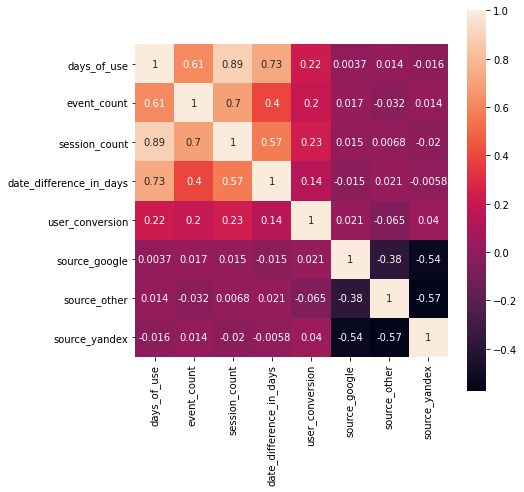

In [43]:
cm = events_pivot.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(7,7))

# тепловая карта с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
ax.set_ylim(
    8, 0
)  # корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

Матрица корреляции показываает, что есть ряд показателей с достаточно высокой корреляцией с конверсией:

    - количество сессий, 
    - количество дней использования,
    - количество событий.

Так как количество дней и сессий очень сильно взаимосвязано, уберем одну из характеристик из расчета.


Теперь данные готовы для проведения кластеризации.

### Кластеризация пользователей

Подготовим дендрограмму

In [44]:
# Разделение данных на признаки и целевую переменную
X = events_pivot[['days_of_use', 
                  'event_count', 
                  'date_difference_in_days', 
                  'source_google', 
                  'source_other', 
                  'source_yandex']]
y = events_pivot['user_conversion']
# Выбор scaler
scaler = StandardScaler()
# Преобразование и трансформация данных
X_st = scaler.fit_transform(X)

Построим матрицу расстояний на стандартизированной матрице признаков и нарисуем дендрограмму.

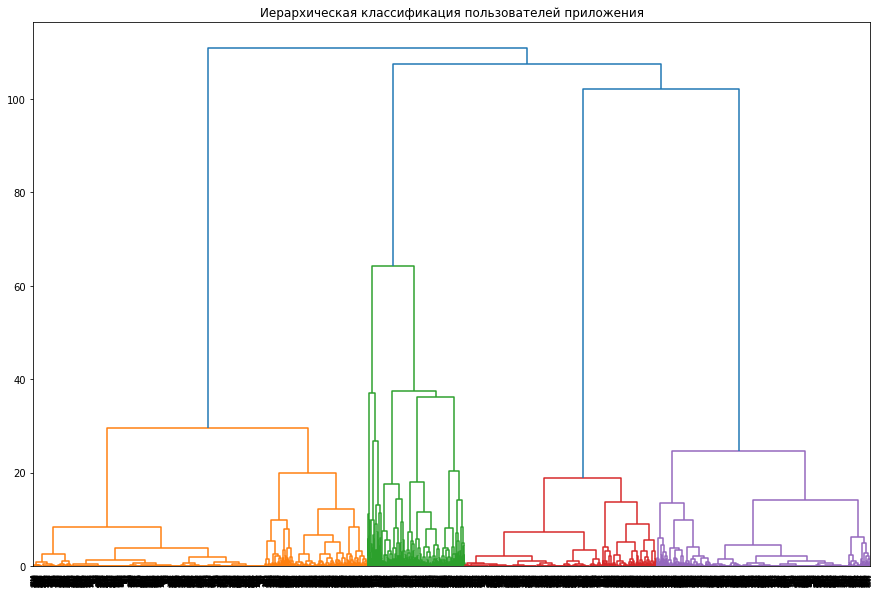

In [45]:
# Модель кластеризации
linked = linkage(X_st, method = 'ward') 
# Демонстрация дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая классификация пользователей приложения')
plt.show() 

На основании полученной диаграммы мы можем выделить от 3 до 5 наполненных кластеров. Остановимся на 3 кластерах. Теперь мы можем обучить модель кластеризации. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров мы приняли n=3. 

In [46]:
# Обучение модели
km = KMeans(n_clusters=3, random_state=0) # задаём число кластеров, равное 3, и фиксируем значение random_state для воспроизводимости результата
# Предсказание принадлежности к классу
labels = km.fit_predict(X_st) # применяем алгоритм к данным и формируем вектор кластеров 

### Общие характеристики сегментов

Рассмотрим средние значения признаков для классов.

In [47]:
# Добавление столбца с номером кластера в таблицу с данными
events_pivot['label'] = labels
print(events_pivot['label'].value_counts())
print(events_pivot['label'].value_counts(normalize=True))
# Расчет средних значений признаков для классов
events_pivot.groupby(labels).mean()

1    1934
0    1230
2    1129
Name: label, dtype: int64
1    0.450501
0    0.286513
2    0.262986
Name: label, dtype: float64


,days_of_use,event_count,session_count,date_difference_in_days,user_conversion,source_google,source_other,source_yandex,label
0,1.860163,15.826016,2.452846,2.786992,0.185366,0,1,0,0
1,1.789555,17.728025,2.338676,2.580145,0.247156,0,0,1,1
2,1.831709,18.108946,2.504872,2.480957,0.243578,1,0,0,2


Таким образом, метод кластеризации разделил пользователей по источникам трафика: google, yandex и другой. будем пользоваться этой классификацией.

In [48]:
# Заменим название сегментов на название источника
events_pivot['label'] = events_pivot[['source_google', 'source_yandex', 'source_other']].idxmax(axis='columns')
events_pivot['label'] = events_pivot['label'].str.replace('source_','')
# Проверим - запросим первые 5 строк.
events_pivot['label'].head()

0     other
1    yandex
2    yandex
3    google
4    yandex
Name: label, dtype: object

Среди пользователей 1934 приходится на yandex, 1129 - на google, еще 1230 - на другие источники. Уровень конверсии через yandex и google выше - около 24-25%, из иных источников - около 19%. Также пользователи yandex и google совершают немного больше действий - 18 по сравнению с 16 от иных источников.

***Вывод***

Выделение пользователей по источнику установки приложения позволило выбрать три равные по объему группы. В целом, поведение этих групп похоже. Пользователи yandex и google совершают несколько больше действий в приложении и имеют несколько более высокую конверсию, чем пользователи из иных источников.

## Различия сегментов по основным показателям

### Уровень удержания по сегментам

Сравним уровень удержания по сегментам. 

cohort_size    0         1         2         3  \
user_conversion label                                                    
0               google          706  1.0  0.118980  0.059490  0.059490   
                other           799  1.0  0.111389  0.072591  0.078849   
                yandex         1220  1.0  0.113115  0.068033  0.060656   
1               google          232  1.0  0.262931  0.159483  0.142241   
                other           193  1.0  0.279793  0.233161  0.202073   
                yandex          398  1.0  0.226131  0.170854  0.165829   

                               4         5         6  
user_conversion label                                 
0               google  0.049575  0.036827  0.039660  
                other   0.043805  0.070088  0.037547  
                yandex  0.055738  0.046721  0.043443  
1               google  0.120690  0.099138  0.120690  
                other   0.108808  0.129534  0.108808  
                yandex  0.090452  0.092965  0.095477

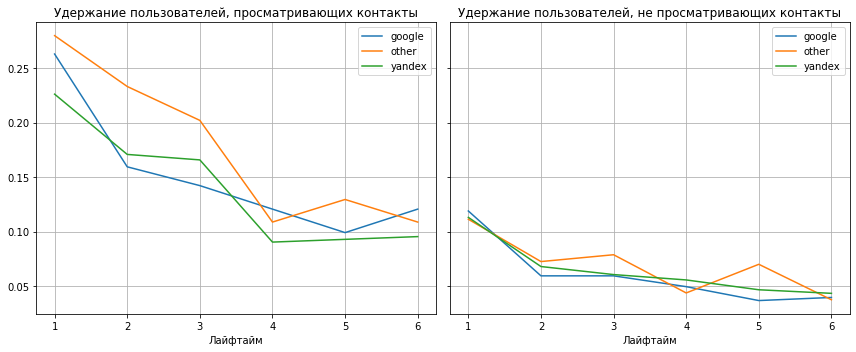

In [49]:
# Расчет удержания
retention_raw, retention_grouped, retention_history = get_retention(
    events_pivot,
    sessions_pivot,
    observation_date,
    horizon_days = 7,
    dimensions=['label'],
    ignore_horizon=False,
)
# Демонстрация общей таблицы удержания
display(retention_grouped)
# Визуализация удержания
plot_retention(retention_grouped, horizon = 7, window=7)

Удержание пользователей, просматривающих контакты, на 7-дневном горизонте несколько выше у google - 12% против 10% у yandex и других источников. 

### Время, проведенное в приложении по сегментам

Сравним время, проведенное в приложении по сегментам

In [50]:
# Расчет времени, проведенного в приложении 
time_raw, time_grouped = get_time_in_app(
    events_pivot,
    sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=['label'],
    ignore_horizon=False,
)
time_grouped

cohort_size          0          1          2  \
user_conversion label                                                  
0               google          706  18.690198   9.802857  12.884524   
                other           799  15.931014  16.087416  13.178103   
                yandex         1220  18.720549  16.520870  14.310241   
1               google          232  25.278233  22.472131  13.536216   
                other           193  21.050725  16.022963  18.473778   
                yandex          398  26.343920  28.273444  24.060441   

                                3          4          5          6  
user_conversion label                                               
0               google  14.667381  11.140857  15.085385  15.046071  
                other    8.421905   5.484286  13.121607  12.363333  
                yandex  14.498243  17.282647  15.705965  13.797170  
1               google  20.248182  19.470714  15.453043  18.683571  
                other    9.292821  24.283810  18.666000  21.121905  
                yandex  18.158182  13.187778  15.641351  17.340789

Более высокое время на 7-дневном горизонте среди не просмотревших контакты пользователей у пользователей google, среди просмотревших контакты - у пользователей других сетей.

### Частота пользования по сегментам

In [51]:
# Расчет количества действий, проведенного в приложении 
events_raw, events_grouped = get_event_count(
    events_pivot,
    sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=['label'],
    ignore_horizon=False,
)
events_grouped

cohort_size          0          1          2  \
user_conversion label                                                  
0               google          706  10.498584   5.833333   7.357143   
                other           799   9.127660   7.415730   7.017241   
                yandex         1220  10.122131   8.978261   7.927711   
1               google          232  12.077586  10.639344   8.162162   
                other           193  10.803109   9.185185   7.977778   
                yandex          398  12.879397  13.588889  10.588235   

                               3          4         5          6  
user_conversion label                                             
0               google  6.261905   7.057143  9.230769   7.071429  
                other   6.142857   3.942857  6.785714   6.900000  
                yandex  7.810811   9.750000  7.350877   6.056604  
1               google  9.333333   8.714286  8.173913   9.250000  
                other   6.256410  15.047619  9.840000  11.761905  
                yandex  7.984848   5.666667  8.054054   8.605263

На семидневном горизонте выше частоста пользования среди пользователей без конверсии у google и других источников, среди пользователей после конверсии - у пользователей других источников.

### Конверсия по сегментам

In [52]:
# Расчет конверсии
conversion_raw, conversion_grouped = get_conversion(
    profiles = events_pivot,
    sessions = sessions_pivot,
    observation_date = mobile_dataset.event_time.max(),
    horizon_days = 7,
    dimensions=['label'],
    ignore_horizon=False,
)
conversion_grouped

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
label,,,,,,,,
google,938,0.191898,0.204691,0.211087,0.215352,0.221748,0.224947,0.230277
other,992,0.134073,0.147177,0.156250,0.159274,0.162298,0.165323,0.171371
yandex,1618,0.184796,0.200247,0.208900,0.216316,0.220643,0.227441,0.229913


В первый день конверсия среди пользователей google составляет 19%, yandex - 18.5%, других источников - 13%.
На седьмой день конверсия доходит до 23% у yandex и google, 17% у других источников.

<Figure size 1080x360 with 0 Axes>

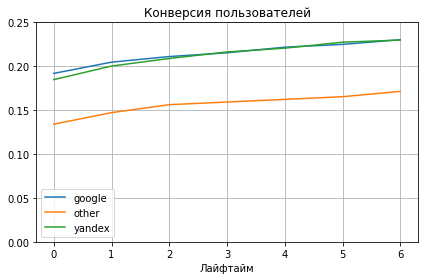

In [53]:
plot_conversion(conversion_grouped, horizon=7)

**Вывод**

Анализ сегментов показывает 
- по уровню удержания на 7 дневном горизонте все источники близки, для пользователей с конверсией этот уровень составляет 10-12%, 
- по событиям и времени в приложении сегменты также достаточно близки, немного больше событий и времени в приложении среди пользователей без конверсии из google, с конверсией - из иных источников,
- сама конверсия выше для пользователей yandex и google, ниже - из иных источников.

## Проверка гипотез

Мы проверим следующие гипотезы:

1. Относительно различий пользователей, использующих google и yandex:
* НО - нет значимых отличий в уровне конверсии пользователей, использующих google и yandex,
* Н1 - существуют значимые отличия в уровне конверсии пользователей, использующих google и yandex.

2. Относительно различий в частоте действий пользователей в выходные (праздничные) и будние дни:
* НО - нет значимых отличий в частоте действий пользователей в выходные (праздничные) и будние дни,
* Н1 - существуют значимые отличия в частоте действий пользователей в выходные (праздничные) и будние дни.

Для этого подготовим данные, функцию по определению разницы между выборками и проведем сравнение и проанализируем полученные результаты.

### Подготовка данных для анализа результатов  статистического теста 

In [54]:
Подготовим сводную таблицу с информацией о количестве пользователей и конверсии по источникам.

SyntaxError: invalid syntax (1817586325.py, line 1)

In [ ]:
# Подготовка сводной таблицы
test_sources = events_pivot.pivot_table(index = 'label', 
                                        aggfunc = {'user_id': 'nunique', 'user_conversion': 'sum'})
# Удаление строки, не участвующей в сравнении
test_sources = test_sources.drop('other', axis=0)
# Демонстрация таблицы
test_sources

Теперь таблица по источникам готова, создадим таблицу по дням недели.

In [ ]:
sessions_pivot['weekday'] = sessions_pivot.first_event_time.dt.weekday

# Подготовка сводной таблицы
test_weekday = sessions_pivot.pivot_table(index = 'weekday', 
                                        aggfunc = {'events_in_session': 'sum', 'user_id':'nunique'})
# Демонстрация таблицы
test_weekday

Данные подготовлены, мы можем тестировать гипотезу.

### Подготовка функции для тестирования статистических гипотез

In [ ]:
# Подготовка функции
def stat_test(successes_1, successes_2, trials_1, trials_2, sample_1, sample_2, metric, 
              alpha = 0.05):    
    # Пропорции успехов в первой и второй группе
    p1 = successes_1 / trials_1
    p2 = successes_2 / trials_2
    # Пропорции успехов в комбинированной группе
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2) 
    # Разница пропорций в датасетах
    difference = p1 - p2
    # Расчет статистики в стандартных отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt (p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2 ))
    # Создание стандартного нормального распределения (среднее - 0, стандартное отклонение - 1)
    distr = stats.norm (0, 1)
    # Расчет уровня вероятности
    p_value = (1 - distr.cdf(abs(z_value)))*2
    print(f'Сравнение групп {sample_1} и {sample_2}')
    print(
        f'Н0: Доли пользователей по характеристике \'{metric}\', \
в группах {sample_1} и {sample_2} статистически значимо не различаются.')
    print(
        f'Н1: Доли пользователей по характеристику \'{metric}\', \
в группах {sample_1} и {sample_2} имеют статистически значимые различия.')
    print((f'Уровень p-значения: {p_value:.3f}'))
    if p_value >= alpha:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
    else:
        print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
        print (f'Различие составляет {difference:.2%}')
    print('*****')

Функция готова к анализу

### Результаты тестирования гипотезы об источниках трафика

Проанализируем результаты статистического теста. Установим порог значимости в 5%.

In [ ]:
# Рассчитаем "успехи" и "попытки" по сводной таблице
successes_1 = test_sources.loc['google', 'user_conversion']
successes_2 = test_sources.loc['yandex', 'user_conversion']
trials_1 = test_sources.loc['google', 'user_id']
trials_2 = test_sources.loc['yandex', 'user_id']
# Проведем статистический тест
stat_test(successes_1 = successes_1, 
          successes_2 = successes_2, 
          trials_1 = trials_1, 
          trials_2 = trials_2, 
          sample_1 = 'источник google', 
          sample_2 = 'источник yandex', 
          metric = 'конверсия')

**Вывод:**

Статистический тест проведен успешно. По его результатам обе группы продемонстрировали отсутствие отличие в долях по конверсии.

### Результаты тестирования гипотезы о частоте использования по дням

Сравним экспериментальную группу (248) и первую из контрольных групп, группу 246.

In [ ]:
# Среднее количество пользователей в рабочие дни
successes_1 = test_weekday.iloc[:5, 1].mean()
# Среднее количество пользователей в нерабочие дни
successes_2 = test_weekday.iloc[5:, 1].mean()
# Среднее количество событий в день в рабочие дни - попытки
trials_1 = test_weekday.iloc[:5, 0].mean()
# Среднее количество событий в день в нерабочие дни - попытки
trials_2 = test_weekday.iloc[5:, 0].mean()
# Проведем статистический тест
stat_test(successes_1 = successes_1, 
          successes_2 = successes_2, 
          trials_1 = trials_1, 
          trials_2 = trials_2, 
          sample_1 = 'пользователи, открывающие приложение в рабочие дни,', 
          sample_2 = 'пользователи, открывающие приложение в нерабочие дни', 
          metric = 'частота использования')

In [ ]:
# Рассчитаем "успехи" и "попытки" по сводной таблице
successes_1 = test_sources.loc['google', 'user_conversion']
successes_2 = test_sources.loc['yandex', 'user_conversion']
trials_1 = test_sources.loc['google', 'user_id']
trials_2 = test_sources.loc['yandex', 'user_id']
# Проведем статистический тест
stat_test(successes_1 = successes_1, 
          successes_2 = successes_2, 
          trials_1 = trials_1, 
          trials_2 = trials_2, 
          sample_1 = 'источник google', 
          sample_2 = 'источник yandex', 
          metric = 'конверсия')

**Вывод**

**Вывод:**

Статистический тест проведен успешно. По его результатам обе группы продемонстрировали отсутствие отличие в долях по частоте использования приложения.

## Общий вывод

В результате анализа иы выделили пользователей, которые различаются по метрикам:

1. retention rate - пользователи, пришедшие из разных источниках имеют примерно равный уровень удержания - от 10 до 12%, но пользователи yandex более многочисленны,
2. время, проведённое в приложении - среди конвертированных пользователей больше всего времени проводят пользователи из других источников, среди пользователей без конверсии - перешедшие из google, в целом в день на недельном горизонте пользователи, если заходят в приложение проводят там не менее 12 минут (без конверсии) и 18 минут (с конверсией). 
3. частота действий - за время проведенное в приложении пользователи успевают совершить 6-7 действий (без конверсии), 10-12 действий с конверсией, 
4. конверсия в целевое действие — просмотр контактов. Общий уровень конверсии на 7 дневном горизонте - около 23% у yandex и google, 17% у пользователей из других источников. 

На основе поведения при регистрации (использованного источника) нами были выделены следующие сегменты:

- пользователи yandex - наиболее многочисленная группа, 45% пользователей. Характеризуется достаточно высоким уровнем удержания и конверсии, при условии, что затраты на привлечение одинаковы - это самый массовый и потенциально прибыльный сегмент,
- пользователи google - достаточно многочисленная группа - 26% пользователей, характеризуется достаточно высоким уровнем удержания, конверсии, а также высокой частотой пользования пользователей, просматривающих контакты.
- пользователи из других источников составляют 28% пользователей, характеризуются немного меньшим уровнем удержания и значительно меньшим уровнем конверсии, среди них больше тех, кто проводит дольше времени в приложении без конверсии, возможно есть какие-то барьеры, которые им надо преодолеть, чтобы перейти в пользователи с конверсией. 

В ходе анализа мы проверяли следующие гипотезы:
1. Пользователи, установившие приложение по ссылке из `yandex` и из `google` демонстрируют разную конверсию в просмотры контактов.*
2. Пользователи пользуются приложением с различной частотой в выходные (праздничные) и будние дни.

Статистический анализ показал отсутствие значимых отличий между группами пользователей в обоих случаях.

Важно учитывать при развитии приложения:
- быстрая конверсия характеризует пользование приложением. В первые сутки конверсия составляет 17% пользователей, в первую неделю "дорастает" до 21%, без ограничения времени достигает 22.8%. Это означает, что необходимо направить особую активность на стимулирование просмотра контактов в первый день и в первую сессию использования приложения,
- приложение характеризуется достаточно большим количеством действий в рамках сессии и достаточно высокой длительностью сессии, следует это учитывать при планировании взаимодействия с пользователями.
- большинство сессий в приложении происходит днем и вечером, то есть приложением могут пользоваться во время работы(учебы), а не только в свободно время,
- сессии, в которые происходят конверсии насыщеннее событиями (10 событий против 8) и длиннее по времени (22 минуты против 12) по сравнению с сессиями, в которых конверсии не происходит, следует поддерживать более длинные сессии, стимулировать максимально подробное заполнение объявлений, чтобы пользователю, ищущему вещи было что читать и какую информацию анализировать,
- сценарии пользования приложением покаазывают - пользователь не всегда работает с поиском, есть также очень распространенные группы пользователей 
   - сосредоточенные на изображениях - они просматривают фото и исходя из фото принимают решение о просмотре контактов,
   - ориентированные на место - они ищут на карте вещи, которые им удобно было бы забрать, видимо ориентируясь на близость местоположения.
   Следует поощрять использование фотографий и точного местоположения в объявлении, возможно сделать пару фотографий и указание места с точностью до улицы обязательным для повышения конверсии.

Для более успешного анализа на следующих этапах было бы полезно:
- установить систему логирования сессий, чтобы более корректно характеризовать пользовательскую активность,
- если используются платные каналы привлечения пользователей, учитывать их стоимость для определения ценности пользователей и эффективности каналов.

Надеемся наши выводы помогут усовершенствовать взаимодействие с пользователями приложения.